In [31]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow-gpu==2.1.0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
#zf = zipfile.ZipFile('/content/drive/My Drive/0_training.zip', "r")
#zf.extractall()
#zf1 = zipfile.ZipFile('/content/drive/My Drive/0_testing.zip', "r")
#zf1.extractall()
zf2 = zipfile.ZipFile('/content/drive/My Drive/mask.zip', "r")
zf2.extractall()

In [0]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import random
import re
from PIL import Image
import cv2
import re
import threading
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler

In [0]:
train_imgs = glob("data/0/training/*.jpg")
TRAIN_LENGTH = len(train_imgs)

test_imgs = glob("data/0/testing/*.jpg")
TEST_LENGTH = len(test_imgs)

BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
"""
class createBatchGenerator():
    def __init__(self, img_folder, batch_size):
        self.batch_size = batch_size
        self.img_folder = img_folder
        self.lock = threading.Lock()
        self.c = 0
    def __iter__(self):
        return self
    def __next__(self):
        with self.lock:
            img = np.zeros((self.batch_size, 224, 224, 3)).astype('float')
            mask = np.zeros((self.batch_size, 224, 224, 1)).astype('float')
            n = os.listdir(self.img_folder)
            random.shuffle(n)
            #initially from 0 to 16, c = 0. 
            for i in range(self.c, self.c+self.batch_size):
                #print(i)
                train_img = cv2.imread(self.img_folder+'/'+n[i])/255.
                train_img =  cv2.resize(train_img, (224, 224))# Read an image from folder and resize
                
                img[i-self.c] = train_img #add to array - img[0], img[1], and so on.
                
                
                mask_path = re.sub("training", "mask", self.img_folder+'/'+n[i])
                mask_path = re.sub("testing", "mask", mask_path)
                mask_path = re.sub("jpg", "png", mask_path)
                camid = re.split('-', re.split('/', mask_path)[-1])[-0]
                mask_path = mask_path[0:6] + re.sub(r'[0-9_-]+', camid, mask_path[6:])
                #print(mask_path)
                train_mask = cv2.imread(mask_path)
                train_mask = cv2.cvtColor(train_mask, cv2.COLOR_BGR2GRAY)
                train_mask = train_mask/255.
                train_mask = cv2.resize(train_mask, (224, 224))
                train_mask = train_mask.reshape(224, 224, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]
                
                mask[i-self.c] = train_mask
                
                
            self.c+=self.batch_size
            if(self.c+self.batch_size>=len(os.listdir(self.img_folder))):
                self.c=0
                random.shuffle(n)
                      # print "randomizing again"
            yield img, mask
            

"""
def data_gen(img_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    random.shuffle(n)
        
    while (True):
        img = np.zeros((batch_size, 224, 224, 3)).astype('float')
        mask = np.zeros((batch_size, 224, 224, 1)).astype('float')
      
        #initially from 0 to 16, c = 0. 
        
        for i in range(c, c+batch_size):
            #print(i)
            train_img = cv2.imread(img_folder+'/'+n[i])/255.
            train_img =  cv2.resize(train_img, (224, 224))# Read an image from folder and resize
            
            img[i-c] = train_img #add to array - img[0], img[1], and so on.
            
            
            mask_path = re.sub("training", "mask", img_folder+'/'+n[i])
            mask_path = re.sub("testing", "mask", mask_path)
            mask_path = re.sub("jpg", "png", mask_path)
            camid = re.split('-', re.split('/', mask_path)[-1])[-0]
            mask_path = mask_path[0:6] + re.sub(r'[0-9_-]+', camid, mask_path[6:])
            #print(mask_path)
            train_mask = cv2.imread(mask_path)
            train_mask = cv2.cvtColor(train_mask, cv2.COLOR_BGR2GRAY)
            train_mask = train_mask/255.
            train_mask = cv2.resize(train_mask, (224, 224))
            train_mask = train_mask.reshape(224, 224, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]
            
            mask[i-c] = train_mask
          
        c+=batch_size
        if(c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
                      # print "randomizing again"
        yield img, mask

In [0]:
train_frame_path = 'data/0/training'

test_frame_path = 'data/0/testing'

# Train the model
#datagenerator = createBatchGenerator(BATCH_SIZE)
train_gen = data_gen(train_frame_path, BATCH_SIZE)
test_gen = data_gen(test_frame_path, BATCH_SIZE)

In [0]:
OUTPUT_CHANNELS = 2
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'mse', 'mae'])

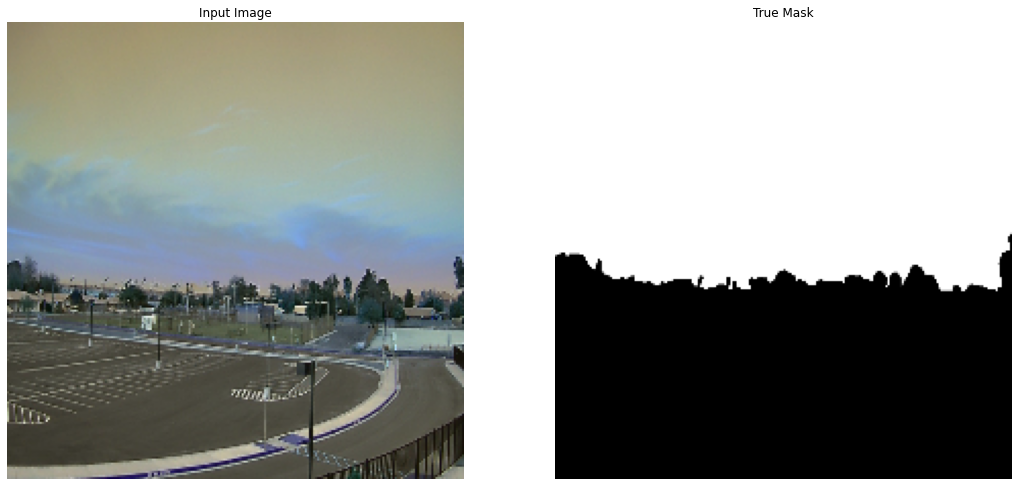

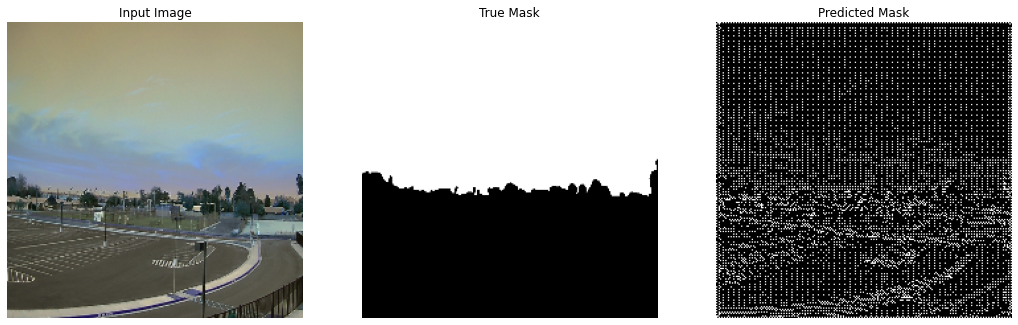

In [39]:
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 2:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

#for image, mask in train.take(2):
#    sample_image, sample_mask = image, mask
#    display_sample([sample_image, sample_mask])
sample_image = cv2.resize(cv2.imread('data/0/testing/65-20130101_143305.jpg'), (224,224))/255.
sample_mask = cv2.resize(cv2.imread('data/0/mask/65.png'), (224,224))/255.
display_sample([sample_image, sample_mask])


def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model=model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_sample([sample_image, sample_mask,
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

lr_reduce = ReduceLROnPlateau(monitor='mse', factor=0.1, min_delta=0.0001, patience=1, verbose=1)
filepath="/content/drive/My Drive/skySegmentationModels/model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')

EPOCHS = 20
VAL_SUBSPLITS = 2
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE

In [0]:
model_history = model.fit_generator(train_gen, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_gen,
                          use_multiprocessing = False,
                          callbacks=[DisplayCallback(), lr_reduce, checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1195 steps, validate for 302 steps
Epoch 1/20
  95/1195 [=>............................] - ETA: 15:44 - loss: 0.4017 - accuracy: 0.8381 - mse: 0.3317 - mae: 0.4994

In [0]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)
x = [train_gen][0]
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

#show_predictions(test_dataset, 3)